# Linear Least Squares -- Relation to Statistics

From Crassidis & Junkins Section 1.2.1

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(1)

In [2]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Generate sample time series data

In [4]:
t = np.linspace(0, 6, 500)
x = np.array([[1, 1, 2, -0.4e-4]]).T
H = np.vstack([t, np.sin(t), np.cos(2*t), np.exp(t)]).T
y = H@x

# Add some normal (gaussian) noise

In [5]:
# Example for Gaussian (normal) random variable

noise_mean = 0
noise_std = 0.5

v = np.column_stack(np.random.normal(noise_mean, noise_std, len(y))).T

In [6]:
y_tilde = y+v

# Plotting

<Axes: xlabel='Time', ylabel='y'>

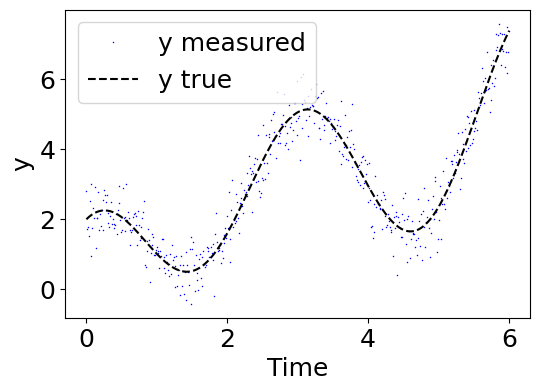

In [7]:
plot_tme(t, y, y_tilde)

# Candidate models

In [8]:
model_1_H = np.vstack([t, np.sin(t), np.cos(2*t)]).T
model_2_H = np.vstack([t+2, t**2, t**3]).T

# Linear Least Squares

$\mathbf{\hat{x}}=(H^{\top}H)^{-1}H^{\top}\mathbf{\tilde{y}}$

### Model 1

In [9]:
x_1_hat = np.linalg.inv(model_1_H.T@model_1_H)@model_1_H.T@y_tilde
print(x_1_hat)

[[1.00806275]
 [1.0460845 ]
 [1.98924779]]


<Axes: xlabel='Time', ylabel='y'>

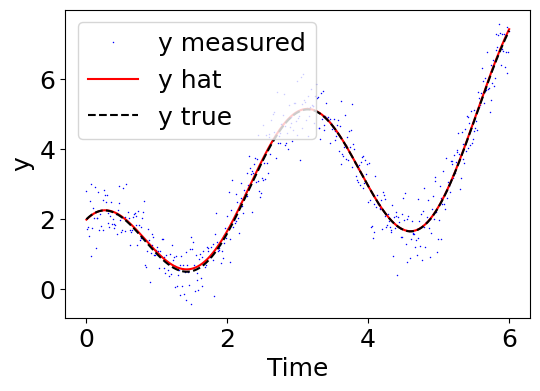

In [10]:
y_1_hat = model_1_H@x_1_hat
plot_tme(t, y, y_tilde, y_1_hat)

### Relation to statistics

In [11]:
model = sm.OLS(y_tilde, model_1_H)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                              7823.
Date:                Fri, 05 Jan 2024   Prob (F-statistic):                        0.00
Time:                        12:40:49   Log-Likelihood:                         -356.47
No. Observations:                 500   AIC:                                      718.9
Df Residuals:                     497   BIC:                                      731.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Actual vs Predicted

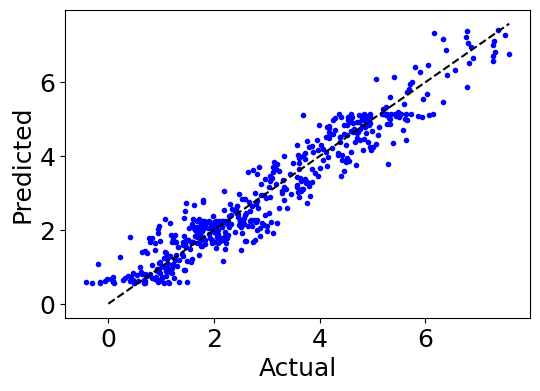

In [12]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(y_tilde, y_1_hat, '.', color='blue')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

line = np.linspace(0, np.max(y_tilde), 10)
ax.plot(line, line, '--', color='black')

#### Residuals

If the noise properties are known, the distribution of the residuals should match the noise.

Text(0, 0.5, 'Residuals')

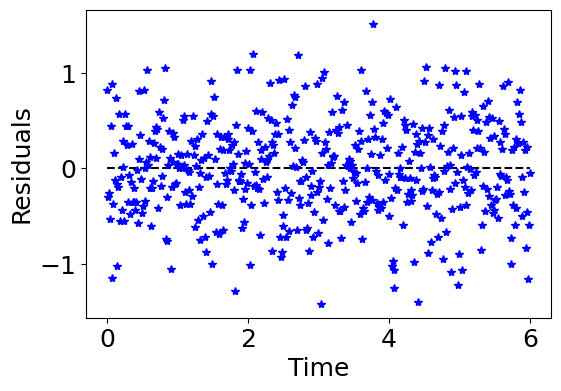

In [13]:
residuals_1 = y_tilde - y_1_hat

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(t, np.ones_like(t)*np.mean(residuals_1), '--', color='black')
ax.plot(t, residuals_1, '*', color='blue')
ax.set_xlabel('Time')
ax.set_ylabel('Residuals')

Text(0, 0.5, 'Occurences (normalized)')

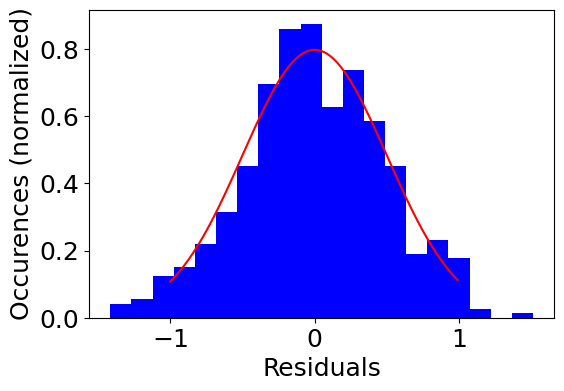

In [14]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.hist(residuals_1, bins=20, color='blue', density=True)

r = np.arange(-1,1,0.01)
N = scipy.stats.norm(noise_mean, noise_std)
pdf = N.pdf(r)
ax.plot(r, pdf, color='red')

ax.set_xlabel('Residuals')
ax.set_ylabel('Occurences (normalized)')

In [15]:
# Quantify the residuals

# std_hat = the standard deviation of the residuals
# RMSE = root mean squared error (error being the residuals)

# If the mean error is zero, RMSE and std(residuals) will be the same

std_hat = np.std(residuals_1)
print('std(residuals):', np.std(residuals_1))

RMSE = np.sqrt(np.mean(residuals_1**2))
print('RMSE:', RMSE)

print('true std of noise:', noise_std)

std(residuals): 0.4936190297113593
RMSE: 0.49361987945443964
true std of noise: 0.5


# QQ plot

Quantile - Quantile plot.

Should be a line with slope 1.

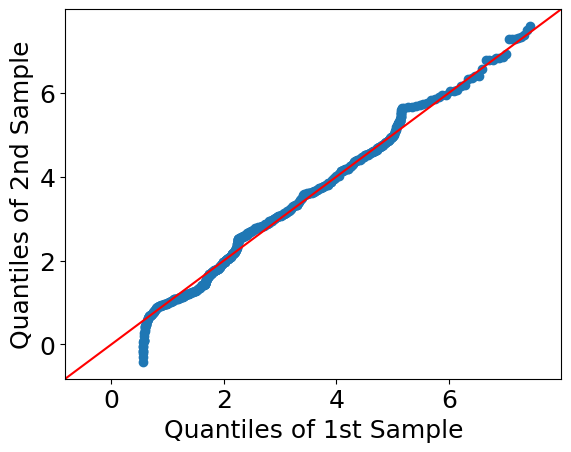

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

sm.qqplot_2samples(np.ravel(y_1_hat), np.ravel(y_tilde), line='45', ax=ax);

### Chi - squared test

(Observed - Expected)^2 / (Expected)

* Top: Calculate as the residuals: y_tilde - y_hat
* Bottom: Comes from the noise distribution you think the data come from, this should be the std dev of the noise

If the filter is consistent, then the distribution of these values across all the observations should follow a chi-squared distribution (in this case, because there is 1 measurement at each step, it would be a chi-square distribution for 1 DOF)

Text(0, 0.5, 'Occurences (normalized)')

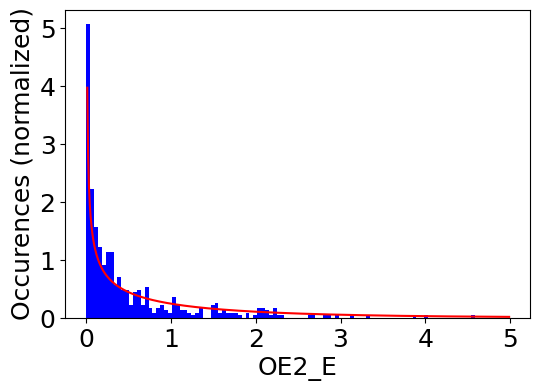

In [26]:
OE2_E = residuals_1**2 / noise_std # residuals^2 / expected
    
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.hist(OE2_E, bins=100, color='blue', density=True)

chi2 = scipy.stats.chi2(1) # 1 degree of freedom -- there is only one measurement per time step

r = np.arange(0, 5, 0.01)
pdf = chi2.pdf(r)
ax.plot(r, pdf, color='red')

ax.set_xlabel('OE2_E')
ax.set_ylabel('Occurences (normalized)')

In [27]:
# Chi-square test

# If the p-value is > some threshold, typically 0.05, or 0.01, then the filter is consistent
print( scipy.stats.chisquare(OE2_E) )

Power_divergenceResult(statistic=array([474.04076691]), pvalue=array([0.78302414]))


# Exercise: repeat the above steps for model 2, compare results